## This notebook is wave propagating in non-reflecting boundary conditions

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
cd(dirname(pwd()))
cd("src")
include("Tools.jl")
include("FiniteDifference.jl")
include("TimeMarching.jl")
include("Initial.jl")
include("Systems.jl")
# include("BoundaryCondition.jl")

using ..Tools
using ..FiniteDifference
using ..TimeMarching
using ..Initial
using ..Systems
# using ..BoundaryCondition
pwd()

"C:\\Users\\liyux\\github\\thermo-network\\src"

In [3]:
    function set_outlet_nonreflect_boundary!(uu::Array,everythinginitial,Δx::Float64,Δt::Float64)
        
#         println("p=",everythinginitial.p[end])
#         println("Δx=",Δx)
#         println("Δt=",Δt)
#         println("uu=",uu[:,end])
        
        L = get_L_from_nonreflect(uu,everythinginitial,Δx)
        d = get_d_from_L(uu,everythinginitial,L)

        gamma = everythinginitial.gamma
        h = everythinginitial.h

        uueverything = UUtoEverything(uu,gamma)

        u = uueverything.u
        ρ = uueverything.ρ

        uuend=Array{Float64,1}(UndefInitializer(), 3)
        uuend[1]=uu[1,end] + (-d[1]).*Δt
        uuend[2]=uu[2,end] + (-u[end].*d[1]-ρ[end].*d[3]+0).*Δt
        uuend[3]=uu[3,end] + (-0.5 .* u[end].*u[end].*d[1]-d[2]./(gamma-1) - ρ[end].*u[end].*d[3] + 0).*Δt

    return uuend
    end

set_outlet_nonreflect_boundary! (generic function with 1 method)

In [4]:
        function get_d_from_L(uu::Array,everythinginitial,L::Array)

                # import variables
                gamma = everythinginitial.gamma

                uueverything = UUtoEverything(uu,gamma)

                u = uueverything.u
                ρ = uueverything.ρ
                c = uueverything.c
                p = uueverything.p

                # get d1,d2,d3,d4,d5
                d = Array{Float64}(UndefInitializer(), 5)
                d[1] = 1 ./ (c[end].^2).*(L[2]+0.5.*(L[5]+L[1]))
                d[2] = 0.5 .* (L[5]+L[1])
                d[3] = 0.5 ./ρ[end]./c[end] .* (L[5]-L[1])
                d[4] = 0
                d[5] = 0

                return d
        end

get_d_from_L (generic function with 1 method)

In [5]:
function get_L_from_nonreflect(uu::Array,everythinginitial,Δx::Float64)

            # import variables
            gamma = everythinginitial.gamma


            uueverything = UUtoEverything(uu,gamma)
    
#             println("p=",uueverything.p[end])
#             println("c=",uueverything.c[end])
#             println("uu=",uu[2,end])
    
            u = uueverything.u
            ρ = uueverything.ρ
            c = uueverything.c
            p = uueverything.p

            # get λ1,λ2,λ3,λ4,λ5
            λ = Array{Float64,1}(UndefInitializer(), 5)
            λ[1] = u[end]-c[end]
            λ[2] = u[end]
            λ[3] = u[end]
            λ[4] = u[end]
            λ[5] = u[end]+c[end]

            # get L1,L2,L3,L4,L5
            L = Array{Float64,1}(UndefInitializer(), 5)
            L[1]=λ[1].*0
            L[2]=λ[2].*(c[end].^2 .* (ρ[end]-ρ[end-1])./Δx-(p[end]-p[end-1])./Δx)
            L[3]=λ[3].*0
            L[4]=λ[4].*0
            L[5]=λ[5].*((p[end]-p[end-1])./Δx+ρ[end].*c[end].*(u[end]-u[end-1])./Δx)
#             println("L=",L)

        return L
        end

get_L_from_nonreflect (generic function with 1 method)

## Parameters for the RHS

In [42]:
P=1;
Ac=1; # unreal
qw=0;

righthand=[0;0;P/Ac*qw]

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

## Initialization (wave)

In [43]:
    # Initial spacial variables
    nx = 201   
    gamma = 1.4
    xlim = (0.0,1.0)
    Δx = (xlim[2]-xlim[1])/nx
    ux,uu=Initial.initial_one_wave(nx,xlim,gamma)
#     ux,uu=Initial.initial_sod(nx,xlim,gamma)

    # get every property from the initial uu
    uueverythinginitial=Systems.UUtoEverything(uu,gamma)
    
    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist = []

#  plot(ux,uueverythinginitial.u,xlabel="z",label="Numerical")

0-element Array{Any,1}

## Time Marching (with boundary condition)


In [44]:
    Δt = 0.0001

    println("Δx=",Δx);
    println("Δt=",Δt);



    #Calculation time
    tf = 1
    tsample = tf/100;
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
        
        t, uu = TimeMarching.stegerwarmingrk1!(t,uu,righthand,ShockTubeSystem(gamma,Δt,Δx))

        uu[:,end]=set_outlet_nonreflect_boundary!(uu,uueverythinginitial,Δx,Δt)
    
        # get every property from uu in every time step
        uueverything=Systems.UUtoEverything(uu,gamma)
    
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uueverything)) : nothing
    end
    

Δx=0.004975124378109453
Δt=0.0001


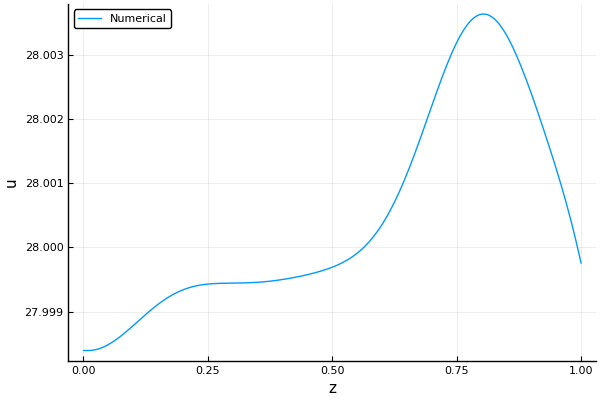

In [53]:
plot(ux,uhist[100].h,xlabel="z",ylabel="u",label="Numerical")

In [10]:
uu[1,end-1]

0.12502677167319629

In [11]:
uueverything.p[end-100]

UndefVarError: UndefVarError: uueverything not defined

In [12]:
uu[:,end-1]

3-element Array{Float64,1}:
 0.12502677167319629
 0.12502341611456613
 2.5624752310293752 

In [13]:
 λ = Array{Float64,2}(UndefInitializer(), 5,3)

5×3 Array{Float64,2}:
 1.42188e-315  1.42188e-315  1.42189e-315
 1.42188e-315  1.42189e-315  1.42189e-315
 1.42188e-315  1.42189e-315  1.43101e-315
 1.42188e-315  1.42189e-315  1.43102e-315
 1.42188e-315  1.42189e-315  1.43018e-315

In [14]:
L=get_L_from_nonreflect_h!(uu::Array,uueverythinginitial,Δx::Float64)

d2=get_d_from_L(uu::Array,uueverythinginitial,L::Array)


UndefVarError: UndefVarError: get_L_from_nonreflect_h! not defined